In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/13288.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/24201.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26556.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26076.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/27577.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/27973.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26452.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/10162.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/12768.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/12551.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/13205.jpg
/kaggle/input/face-expression-recognition-d

In [2]:
import os
import shutil
import cv2
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to original and new directories
original_train_path = "/kaggle/input/face-expression-recognition-dataset/images/train"
new_train_path = "/kaggle/working/filtered_train"

original_validation_path = "/kaggle/input/face-expression-recognition-dataset/images/validation"
new_validation_path = "/kaggle/working/filtered_validation"

# Helper function to load images
def load_images_from_folder(folder):
    images = []
    labels = []
    for emotions in os.listdir(folder):
        emotion_path = os.path.join(folder, emotions)
        for file in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            labels.append(emotions)
    return images, labels

# Load training and validation images
train_images, train_labels = load_images_from_folder(original_train_path)
validation_images, validation_labels = load_images_from_folder(original_validation_path)

# Downsampling the "happy" class to 5000 images
def downsample_class(images, labels, class_name, target_count):
    class_images = [img for img, lbl in zip(images, labels) if lbl == class_name]
    non_class_images = [img for img, lbl in zip(images, labels) if lbl != class_name]
    non_class_labels = [lbl for lbl in labels if lbl != class_name]
    downsampled_class_images = random.sample(class_images, target_count)
    balanced_images = downsampled_class_images + non_class_images
    balanced_labels = [class_name] * target_count + non_class_labels
    return balanced_images, balanced_labels

# Apply downsampling
train_images, train_labels = downsample_class(train_images, train_labels, 'happy', 5000)

# Shuffle the dataset
combined = list(zip(train_images, train_labels))
random.shuffle(combined)
train_images, train_labels = zip(*combined)

# Convert lists to numpy arrays if needed
train_images = np.array(train_images)
train_labels = np.array(train_labels)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

# Remove "disgust" label
def remove_label(images, labels, label_to_remove):
    filtered_images = [img for img, lbl in zip(images, labels) if lbl != label_to_remove]
    filtered_labels = [lbl for lbl in labels if lbl != label_to_remove]
    return filtered_images, filtered_labels

train_images, train_labels = remove_label(train_images, train_labels, 'disgust')
validation_images, validation_labels = remove_label(validation_images, validation_labels, 'disgust')

# Create directories for filtered data
def create_filtered_directory_structure(images, labels, new_path):
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    for label in set(labels):
        label_path = os.path.join(new_path, label)
        if not os.path.exists(label_path):
            os.makedirs(label_path)
        for img, lbl in zip(images, labels):
            if lbl == label:
                img_filename = f"{lbl}_{random.randint(0, 1e6)}.jpg"
                img_path = os.path.join(label_path, img_filename)
                cv2.imwrite(img_path, img)

# Create filtered directory structures
create_filtered_directory_structure(train_images, train_labels, new_train_path)
create_filtered_directory_structure(validation_images, validation_labels, new_validation_path)

# Check new structure
print(f"Train directory structure: {os.listdir(new_train_path)}")
print(f"Validation directory structure: {os.listdir(new_validation_path)}")

# Set up ImageDataGenerators
target_size = (48, 48)  # example target size, adjust as needed
batch_size = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create generators using the new directory structure
train_generator = train_datagen.flow_from_directory(
    new_train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    new_validation_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Verify the new generators
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes.")
print(f"Found {validation_generator.samples} images belonging to {validation_generator.num_classes} classes.")

2024-05-31 03:32:52.178445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 03:32:52.178582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 03:32:52.297619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train directory structure: ['neutral', 'angry', 'surprise', 'happy', 'fear', 'sad']
Validation directory structure: ['neutral', 'angry', 'surprise', 'happy', 'fear', 'sad']
Found 26158 images belonging to 6 classes.
Found 6953 images belonging to 6 classes.
Found 26158 images belonging to 6 classes.
Found 6953 images belonging to 6 classes.


In [3]:
### Model Architecture


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 6

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(learning_rate =0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,479,366 (17.09 MB)

 Trainable params: 4,475,398 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [5]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  9/817 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.1548 - loss: 2.2767 

I0000 00:00:1717126662.598328     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


817/817 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.2106 - loss: 1.9985 - val_accuracy: 0.3165 - val_loss: 1.6679
Epoch 2/50
  1/817 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2188 - loss: 1.9603

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2188 - loss: 1.9603 - val_accuracy: 0.2222 - val_loss: 1.7679
Epoch 3/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2832 - loss: 1.7650 - val_accuracy: 0.3520 - val_loss: 1.6071
Epoch 4/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.3125 - loss: 1.7615 - val_accuracy: 0.4444 - val_loss: 1.4286
Epoch 5/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.3428 - loss: 1.6434 - val_accuracy: 0.4178 - val_loss: 1.4682
Epoch 6/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.3438 - loss: 1.4776 - val_accuracy: 0.4444 - val_loss: 1.2899
Epoch 7/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.3770 - loss: 1.5524 - val_accuracy: 0.4551 - val_loss: 1.3839
Epoch 8/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.2812 - loss: 1.6795 - val_accuracy: 0.4444 - val_loss: 1.4365
Epoch 9/50
817/817 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4144 - loss: 1.4677 - val_accuracy: 0.

218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6303 - loss: 1.0588
Validation Accuracy: 0.6339709758758545
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Confusion Matrix:
 [[ 85  73 246 274 168 113]
 [101  78 272 296 174  97]
 [166 129 501 522 305 201]
 [110  80 324 356 215 131]
 [ 85  78 306 324 219 127]
 [ 76  56 217 237 136  75]]


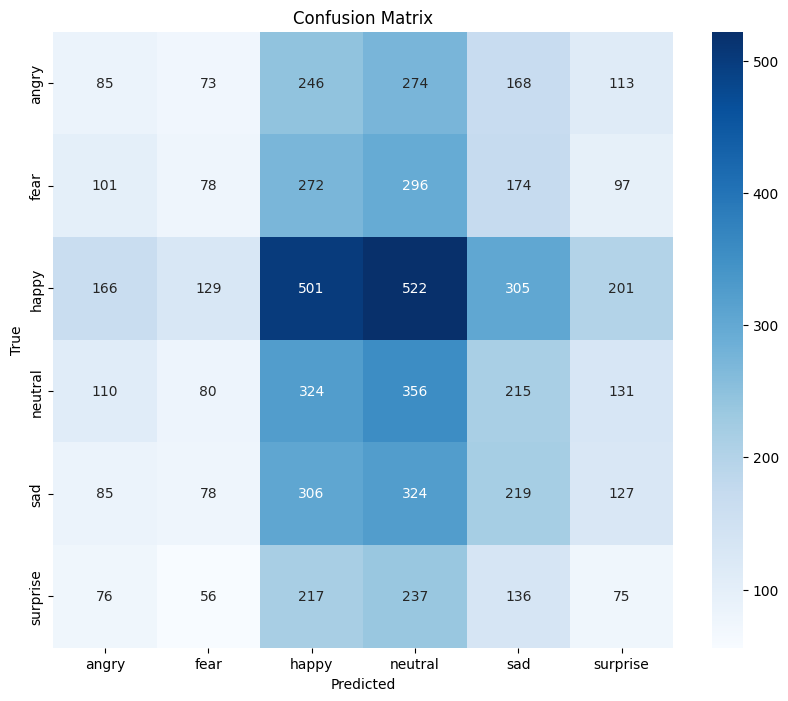

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.09      0.11       959
        fear       0.16      0.08      0.10      1018
       happy       0.27      0.27      0.27      1824
     neutral       0.18      0.29      0.22      1216
         sad       0.18      0.19      0.19      1139
    surprise       0.10      0.09      0.10       797

    accuracy                           0.19      6953
   macro avg       0.17      0.17      0.16      6953
weighted avg       0.18      0.19      0.18      6953



In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy}")

# Predict the labels for the validation data
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate and display the classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6352 - loss: 1.0505
Validation Accuracy: 0.6339709758758545
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Confusion Matrix:
 [[ 78  70 263 265 168 115]
 [ 79  71 268 316 170 114]
 [184 119 484 519 328 190]
 [107  89 330 331 224 135]
 [110  88 286 332 216 107]
 [ 65  57 235 246 111  83]]


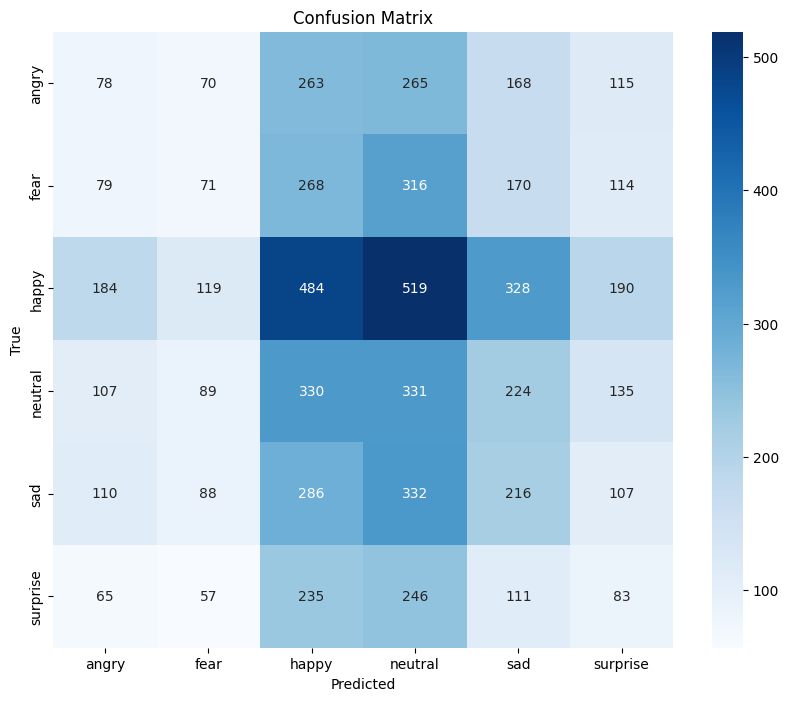

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.08      0.10       959
        fear       0.14      0.07      0.09      1018
       happy       0.26      0.27      0.26      1824
     neutral       0.16      0.27      0.21      1216
         sad       0.18      0.19      0.18      1139
    surprise       0.11      0.10      0.11       797

    accuracy                           0.18      6953
   macro avg       0.16      0.16      0.16      6953
weighted avg       0.18      0.18      0.17      6953



In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy}")

# Predict the labels for the validation data
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate and display the classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


KeyError: 'acc'

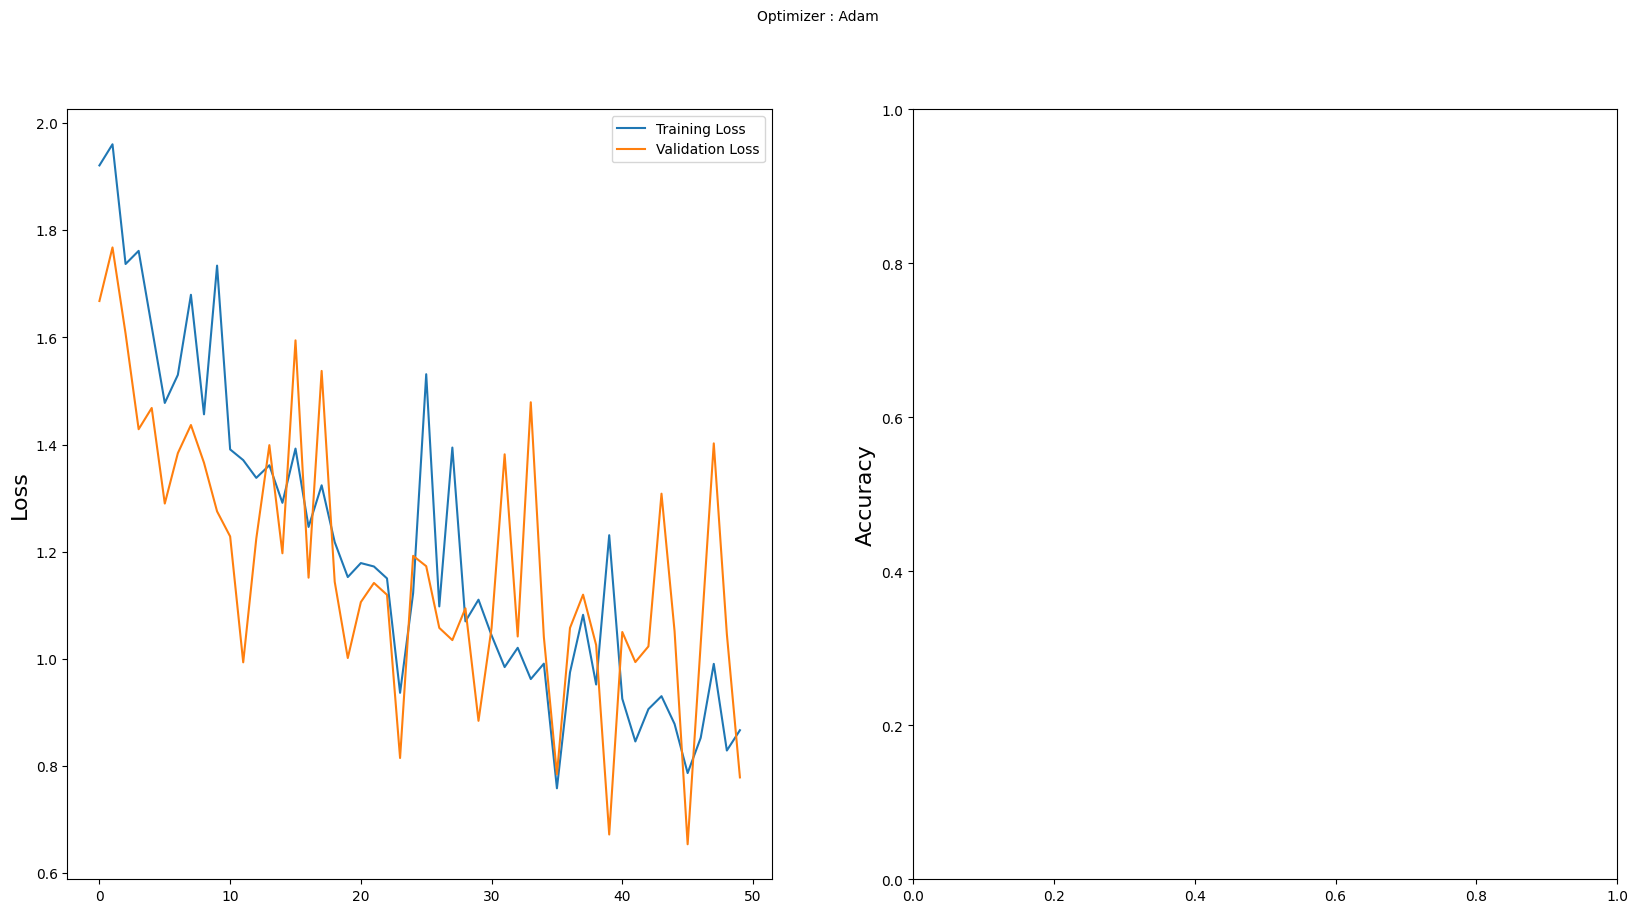

In [8]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6337 - loss: 1.0224
Validation Loss: 1.0436103343963623
Validation Accuracy: 0.6339709758758545
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.08      0.10       959
        fear       0.12      0.06      0.08      1018
       happy       0.26      0.27      0.27      1824
     neutral       0.17      0.29      0.22      1216
         sad       0.17      0.18      0.17      1139
    surprise       0.12      0.11      0.11       797

    accuracy                           0.18      6953
   macro avg       0.16      0.16      0.16      6953
weighted avg       0.17      0.18      0.17      6953

Confusion Matrix
[[ 81  79 272 259 164 104]
 [ 93  57 294 290 176 108]
 [153 135 491 544 312 189]
 [109  95 314 349 212 137]
 [110  80 297 333 201 118]
 [ 77  48 198 234 152  88]]


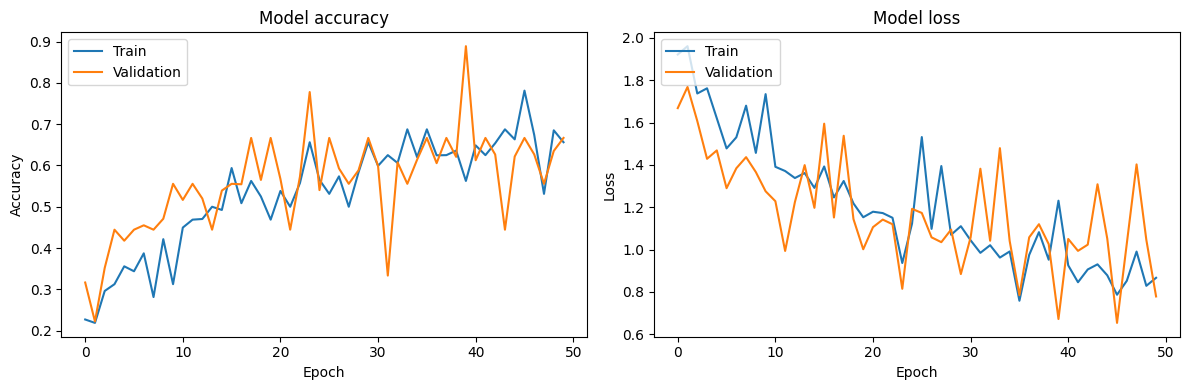

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Get the true labels and predictions
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Print classification report
print('Classification Report')
target_names = list(validation_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# Print confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

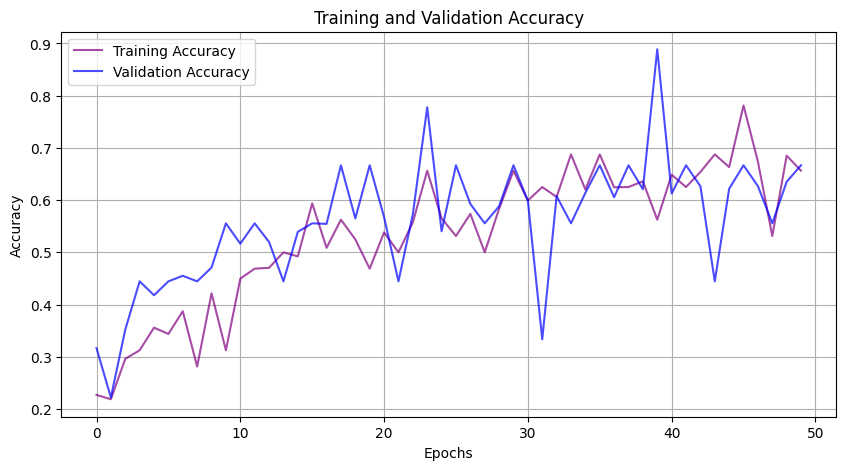

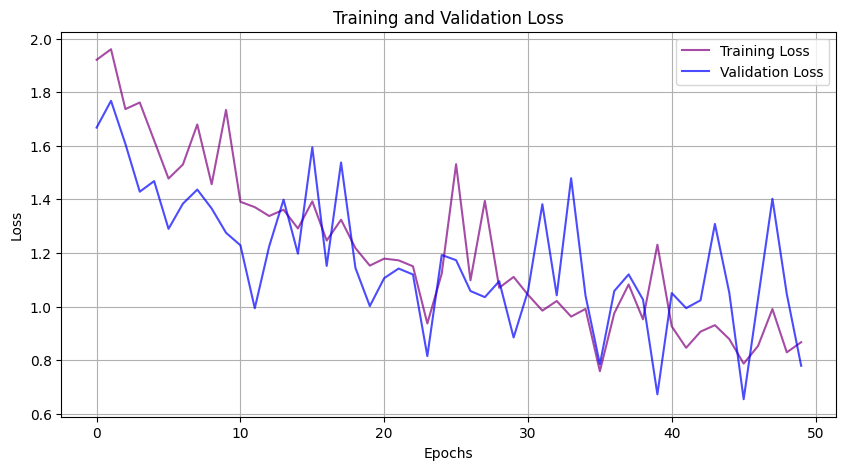

In [12]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output of model.fit() containing training metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'purple', label='Training Accuracy', linewidth=1.5, alpha=0.7)
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', linewidth=1.5, alpha=0.7)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'purple', label='Training Loss', linewidth=1.5, alpha=0.7)
plt.plot(epochs, val_loss, 'b', label='Validation Loss', linewidth=1.5, alpha=0.7)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [15]:
# Serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 with the correct filename extension
model.save_weights("model_weights.weights.h5")
